In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [99]:
from utils import load_twitter_graph_with_feature

G=load_twitter_graph_with_feature()

In [102]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 23370, Edges: 32831

 Node types:
  default: [23370]
    Features: float32 vector, length 23370
    Edge types: default-default->default

 Edge types:
    default-default->default: [32831]
        Weights: all 1 (default)
        Features: none


In [105]:

edge_splitter_test = EdgeSplitter(G)


G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 3283 positive and 3283 negative edges. **


In [106]:

edge_splitter_train = EdgeSplitter(G_test)


G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 2954 positive and 2954 negative edges. **


In [107]:
epochs = 50


In [108]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [109]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [110]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [111]:
x_inp, x_out = gcn.in_out_tensors()

In [112]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [114]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

c:\Users\Mohammadreza\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [115]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 2s 2s/step - loss: 5.1787 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 5.1830
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 5.1787
	binary_accuracy: 0.5000


In [116]:
history = model.fit_generator(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

C:\Users\Mohammadreza\AppData\Local\Temp\ipykernel_26580\2619516608.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
1/1 - 7s - loss: 5.1273 - binary_accuracy: 0.5000 - val_loss: 2.3340 - val_binary_accuracy: 0.5000 - 7s/epoch - 7s/step
Epoch 2/50
1/1 - 6s - loss: 2.3412 - binary_accuracy: 0.5000 - val_loss: 1.6455 - val_binary_accuracy: 0.5000 - 6s/epoch - 6s/step
Epoch 3/50
1/1 - 5s - loss: 1.6387 - binary_accuracy: 0.5000 - val_loss: 1.2449 - val_binary_accuracy: 0.5032 - 5s/epoch - 5s/step
Epoch 4/50
1/1 - 5s - loss: 1.2373 - binary_accuracy: 0.5032 - val_loss: 0.9623 - val_binary_accuracy: 0.5151 - 5s/epoch - 5s/step
Epoch 5/50
1/1 - 5s - loss: 0.9583 - binary_accuracy: 0.5152 - val_loss: 0.7475 - val_binary_accuracy: 0.5355 - 5s/epoch - 5s/step
Epoch 6/50
1/1 - 5s - loss: 0.7420 - binary_accuracy: 0.5416 - val_loss: 0.5797 - val_binary_accuracy: 0.6090 - 5s/epoch - 5s/step
Epoch 7/50
1/1 - 6s - loss: 0.5844 - binary_accuracy: 0.6119 - val_loss: 0.4543 - val_binary_accuracy: 0.7347 - 6s/epoch - 6s/step
Epoch 8/50
1/1 - 6s - loss: 0.4556 - binary_accuracy: 0.7332 - val_loss: 0.3788 - v

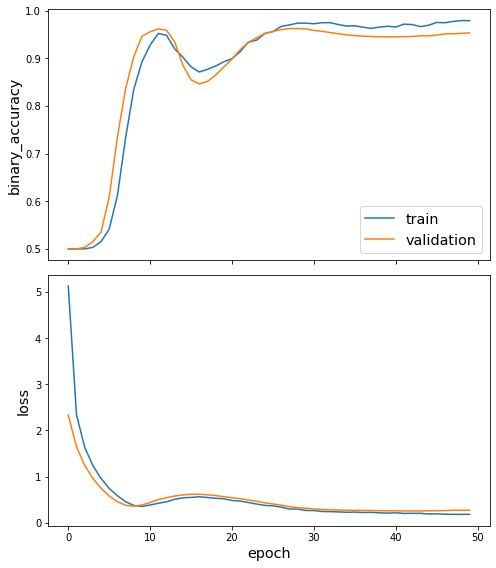

In [117]:
sg.utils.plot_history(history)

In [118]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 2s 2s/step - loss: 0.2706 - binary_accuracy: 0.9534

Train Set Metrics of the trained model:
	loss: 0.1600
	binary_accuracy: 0.9866

Test Set Metrics of the trained model:
	loss: 0.2706
	binary_accuracy: 0.9534
